## Exploring Rossmann Drug Store Sales Data

In [13]:
import pandas as pd

import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('../../assets/datasets/rossmann.csv', skipinitialspace=True, low_memory=False)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [14]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [15]:
store1_data = data[data.Store == 1]

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

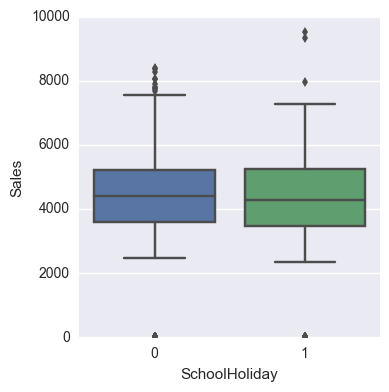

In [16]:
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

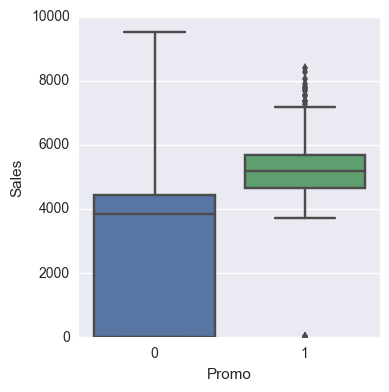

In [17]:
# TODO
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='Promo',
    y='Sales',
    data=store1_data, 
    kind='box'
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

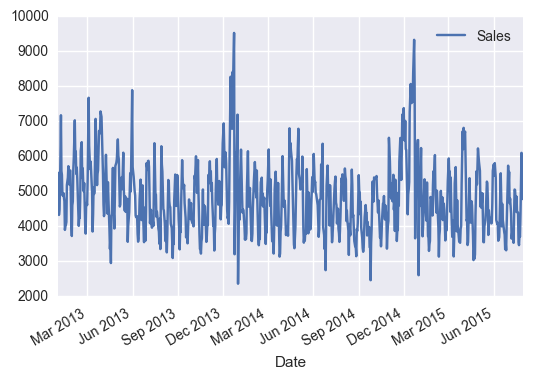

In [18]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

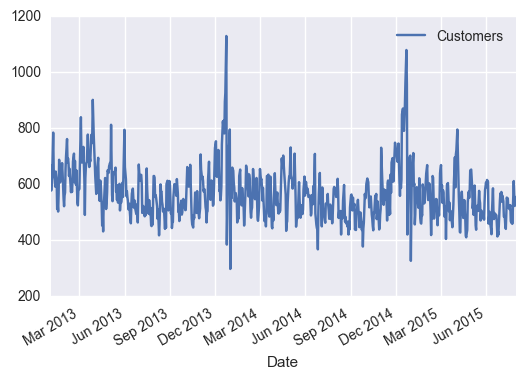

In [19]:
store1_open_data[['Customers']].plot()

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it. Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [20]:
R=data[data.Open==1].Sales.resample('D').mean()
R

Date
2013-01-01    5719.705882
2013-01-02    6255.471647
2013-01-03    5723.913436
2013-01-04    5991.835740
2013-01-05    5376.326107
2013-01-06    7573.894737
2013-01-07    9789.193490
2013-01-08    7918.042534
2013-01-09    7010.500452
2013-01-10    7014.918552
2013-01-11    7275.390045
2013-01-12    5445.693213
2013-01-13    8002.888889
2013-01-14    5327.409955
2013-01-15    4988.770136
2013-01-16    4790.063348
2013-01-17    4865.911472
2013-01-18    5548.833635
2013-01-19    5429.261066
2013-01-20    7978.947368
2013-01-21    7914.249322
2013-01-22    7516.069557
2013-01-23    6997.798555
2013-01-24    6714.653430
2013-01-25    7022.372744
2013-01-26    5278.673285
2013-01-27    7142.400000
2013-01-28    5310.480578
2013-01-29    4925.626016
2013-01-30    5333.735560
                 ...     
2015-07-02    7581.950628
2015-07-03    7657.439856
2015-07-04    5434.718133
2015-07-05    8159.030303
2015-07-06    6768.826750
2015-07-07    5738.800718
2015-07-08    6207.921903
2015-07

In [21]:
R.autocorr()

0.42877053784467889

In [22]:
for i in range(1,30):
    print i, R.autocorr(lag=i)

1 0.428770537845
2 0.260079778181
3 0.183547048998
4 0.0650732802345
5 -0.113821706823
6 -0.149396085164
7 0.151625390858
8 -0.171496255244
9 -0.16636050113
10 -0.048182591706
11 0.0217862585866
12 0.0743102426534
13 0.181494355883
14 0.580928689688
15 0.177484083238
16 0.0835079331106
17 0.0601753836174
18 0.0125316272523
19 -0.10043679733
20 -0.0937223635708
21 0.191777694191
22 -0.0929163225036
23 -0.121159719632
24 -0.0511655721122
25 -0.000929934944821
26 0.0278429316362
27 0.129146823499
28 0.481019569539
29 0.15605558655


In [23]:
from pandas.tools.plotting import autocorrelation_plot

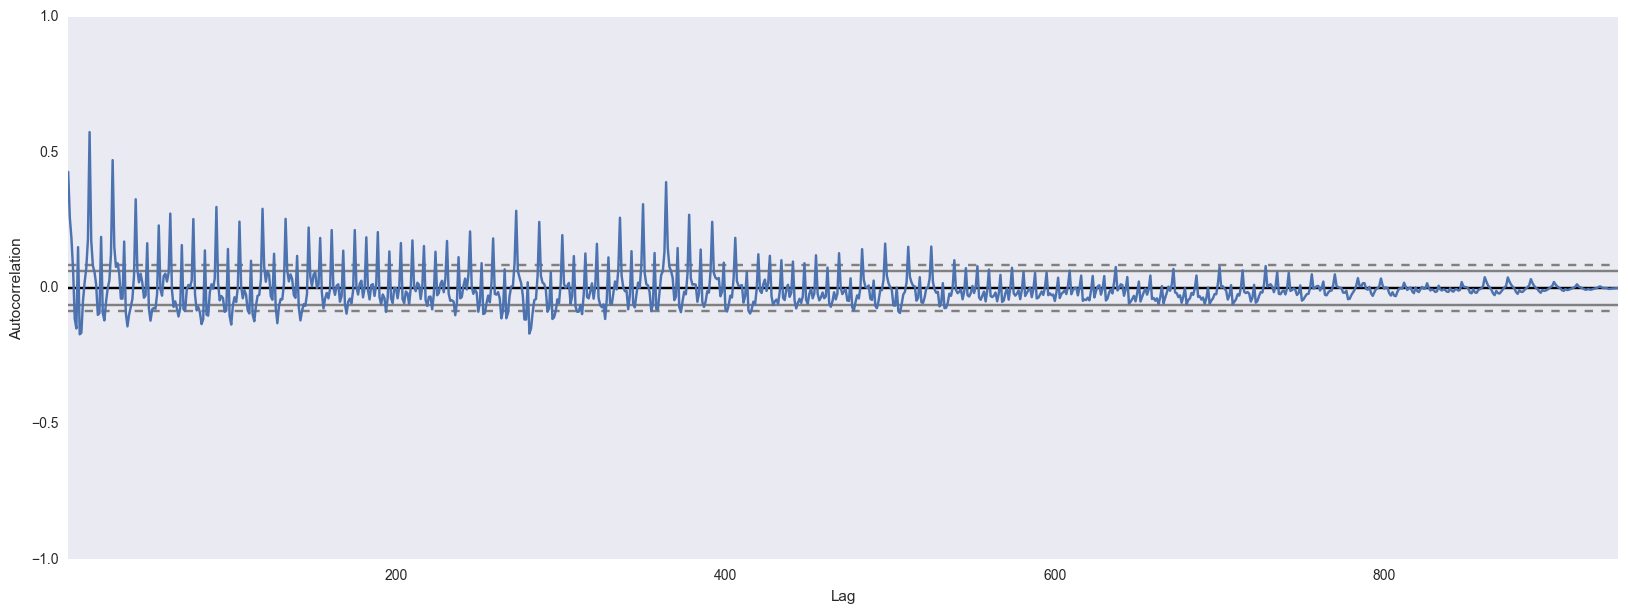

In [28]:
plt.figure(figsize=(20,7))
autocorrelation_plot(R)

(0, 35)

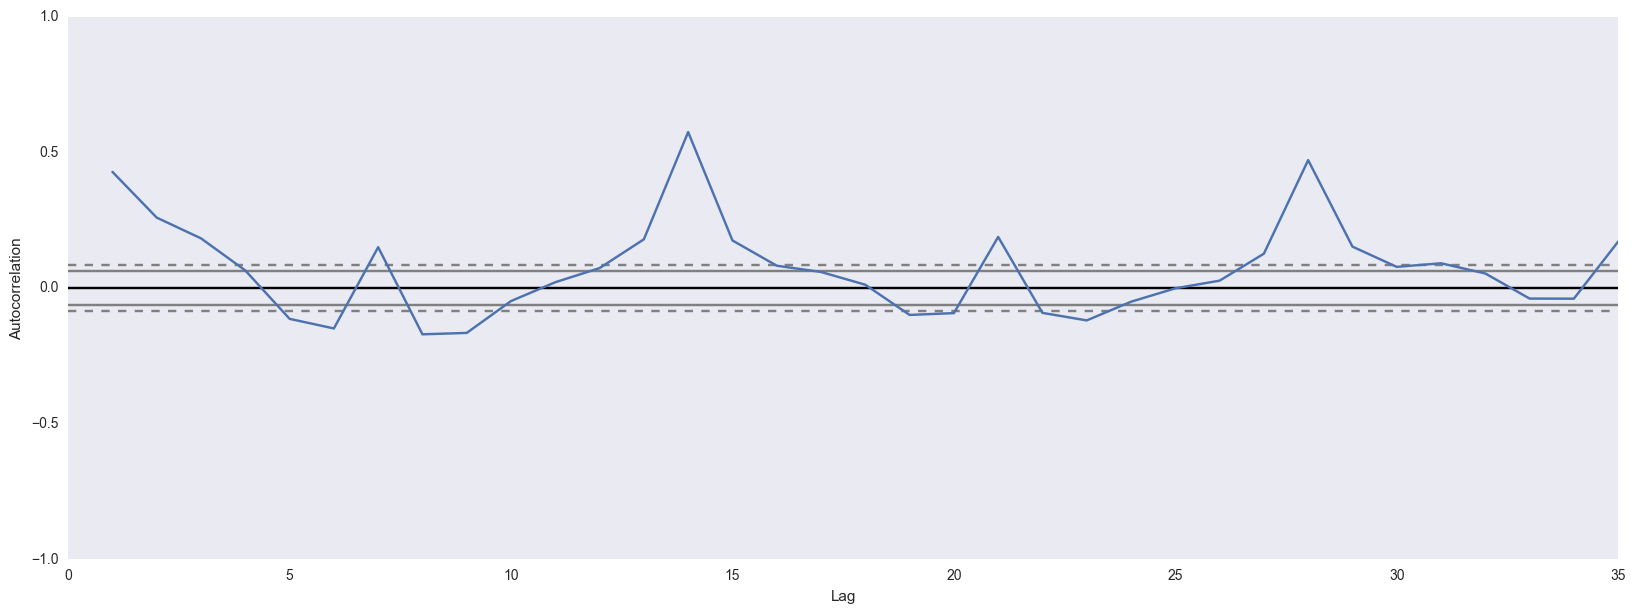

In [29]:
plt.figure(figsize=(20,7))
autocorrelation_plot(R)
plt.xlim(0,35)

In [30]:
R.autocorr(lag=365)

0.25701339164210496

In [31]:
for i in range(360,371):
    print i, R.autocorr(lag=i)

360 -0.0169503922861
361 0.0867236856759
362 0.110282920259
363 0.229177202838
364 0.657496007125
365 0.257013391642
366 0.139001069703
367 0.113729665938
368 0.0711500764414
369 -0.0654537057063
370 -0.0436667390173


In [25]:
#data['Sales'].resample('D', how='mean').autocorr(lag=1)

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [32]:
# resample original sales data mean and median by month
data2=data[data['Open']==1]
R2 = data2.Sales.resample('M').mean()
R2 = data2.Sales.resample('M').median()

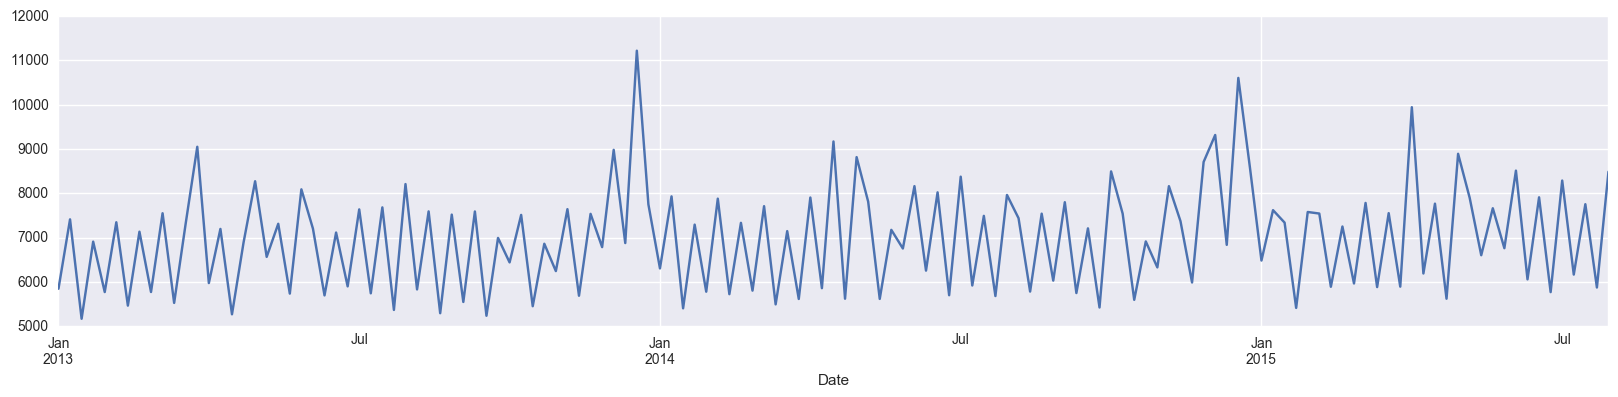

In [45]:
# resample to have the daily average over all stores, then find rolling mean
dss = data2.Sales.resample('W').mean()
dss.plot(figsize=(20,4))

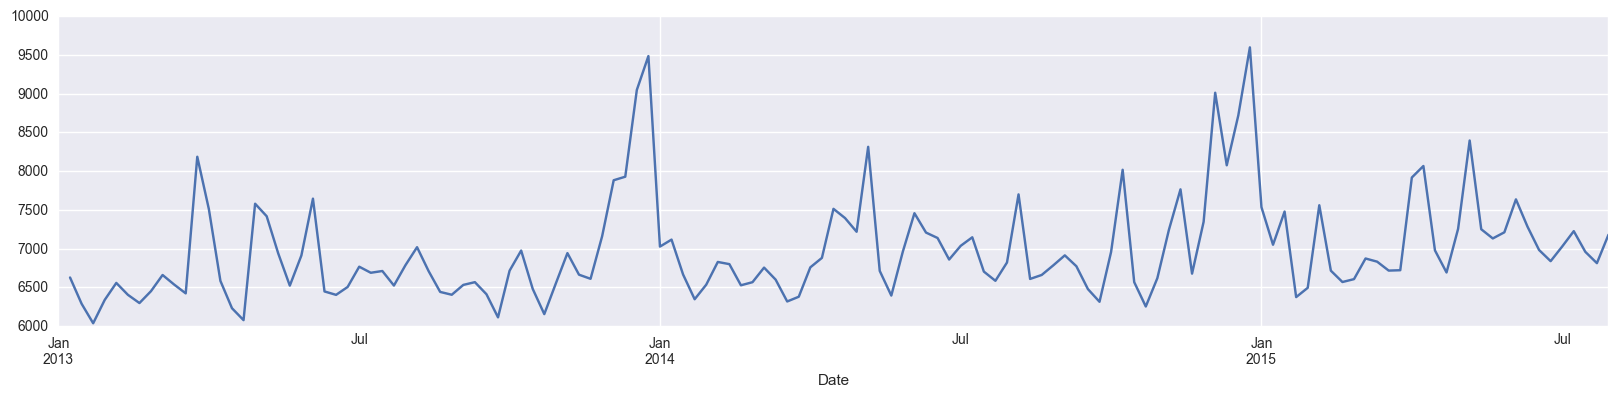

In [46]:
dss.rolling(window=2).mean().plot(figsize=(20,4))

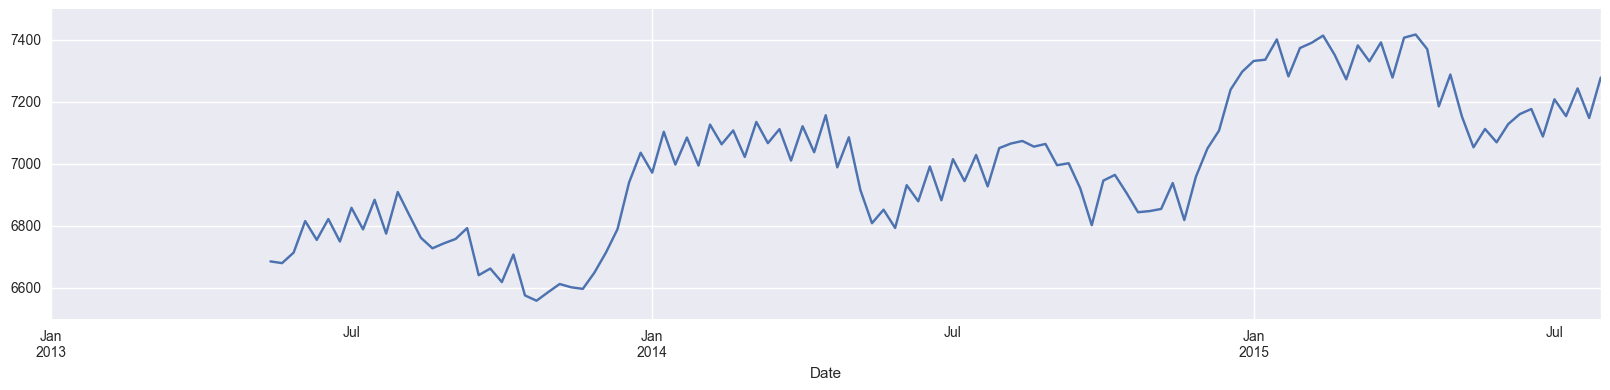

In [47]:
dss.rolling(window=20).mean().plot(figsize=(20,4))

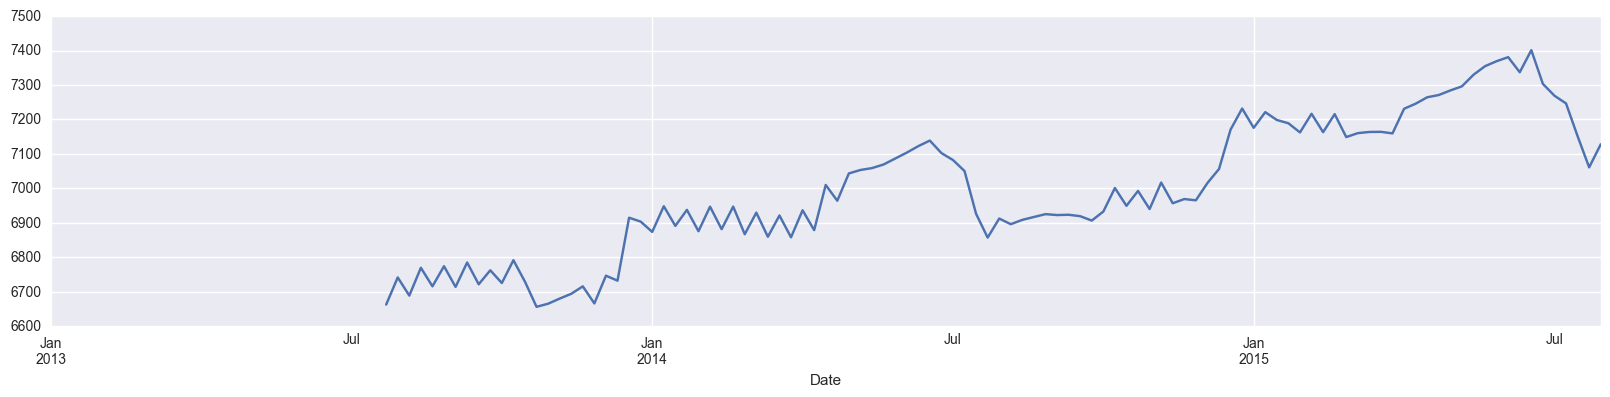

In [49]:
dss.rolling(window=30).mean().plot(figsize=(20,4))

In [21]:
data[['Sales']].resample('M', how=['median', 'mean']).head()

/Users/arahuja/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  if __name__ == '__main__':


Sales             
            median         mean
Date                           
2013-01-31  5194.0  5211.555578
2013-02-28  5421.5  5494.371397
2013-03-31  5844.0  5820.349168
2013-04-30  5464.0  5483.749836
2013-05-31  5585.0  5364.127383

While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [50]:
# Resample to have the daily average over all stores
# daily_store_sales = data[['Sales']].resample('D', how='sum')

# pd.rolling_mean(daily_store_sales, window=3, center=True,).head()

`rolling_mean` (as well as `rolling_median`) takes these important parameters:
    - the first is the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

In [51]:
# pd.rolling_mean(daily_store_sales, window=10, center=True).plot()

### Pandas Window functions
Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.


In [58]:
# calculate diff for open store 1 data
s1d = data2[data2['Store']==1]

In [114]:
data2=data[data['Open']==1]
R3 = s1d.Sales.resample('M').mean()

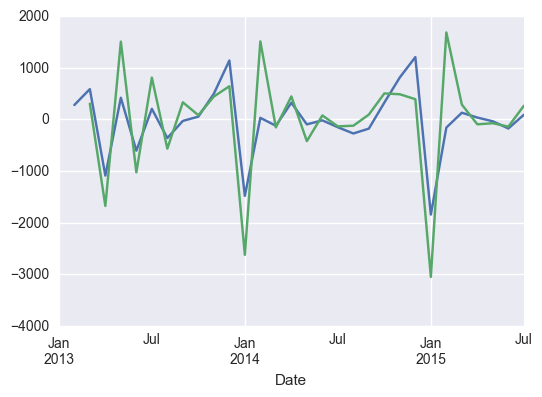

In [117]:
R3.diff().plot()
(R3.diff()).diff().plot()

In [59]:
s1d.sort_index(inplace=True)

/Users/user/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [63]:
s1d.Sales.diff()

Date
2013-01-02       NaN
2013-01-03   -1203.0
2013-01-04     159.0
2013-01-05     511.0
2013-01-07    2179.0
2013-01-08   -1596.0
2013-01-09    -109.0
2013-01-10    -579.0
2013-01-11     -11.0
2013-01-12      71.0
2013-01-14    -235.0
2013-01-15    -817.0
2013-01-16     108.0
2013-01-17      36.0
2013-01-18      83.0
2013-01-19    1055.0
2013-01-21     212.0
2013-01-22     326.0
2013-01-23    -142.0
2013-01-24    -383.0
2013-01-25     391.0
2013-01-26      12.0
2013-01-28   -1543.0
2013-01-29    -330.0
2013-01-30     876.0
2013-01-31     108.0
2013-02-01     924.0
2013-02-02     337.0
2013-02-04    1062.0
2013-02-05    -983.0
               ...  
2015-06-27     702.0
2015-06-29    1178.0
2015-06-30     538.0
2015-07-01    -512.0
2015-07-02     335.0
2015-07-03    -893.0
2015-07-04     132.0
2015-07-06    -438.0
2015-07-07    -709.0
2015-07-08     147.0
2015-07-09     100.0
2015-07-10     -89.0
2015-07-11    -278.0
2015-07-13    1524.0
2015-07-14     -12.0
2015-07-15    -275.0
2015-07-

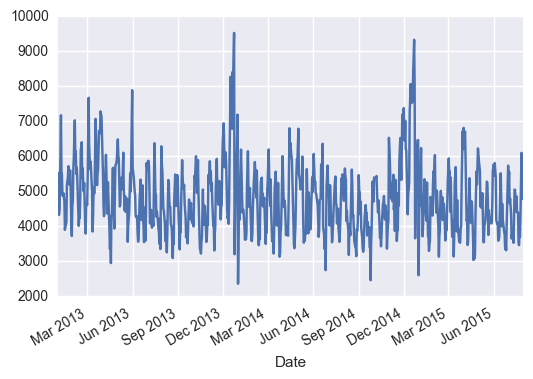

In [62]:
s1d.Sales.plot()

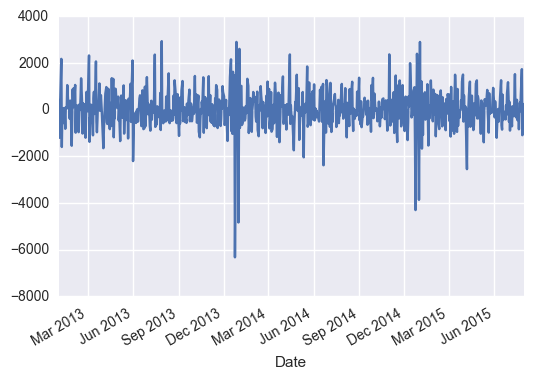

In [70]:
s1d.Sales.diff().plot()

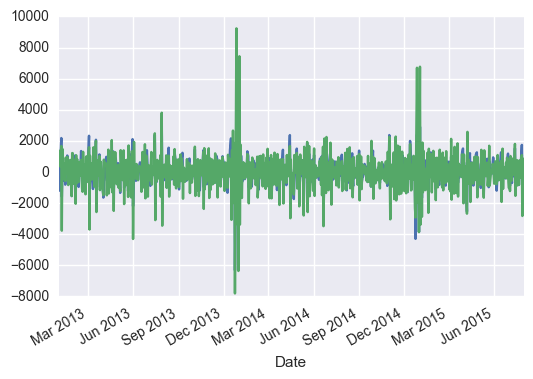

In [103]:
s1d.Sales.diff().plot()
(s1d.Sales.diff()).diff().plot()

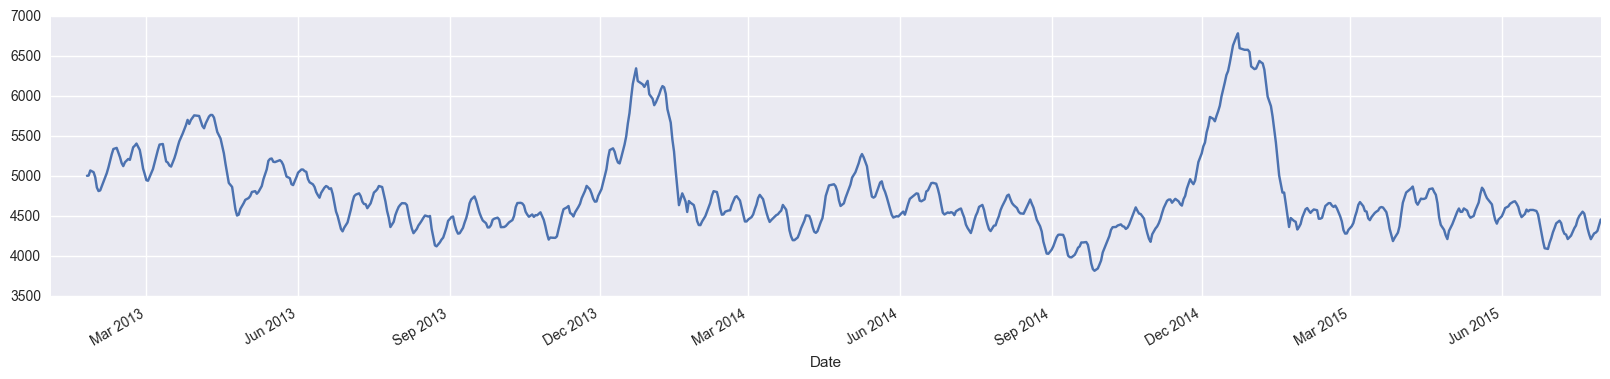

In [67]:
s1d.Sales.rolling(window=20).mean().plot(figsize=(20,4))

In [79]:
data['Sales'].diff(periods=1).head()

Date
2015-07-31       NaN
2015-07-31     801.0
2015-07-31    2250.0
2015-07-31    5681.0
2015-07-31   -9173.0
Name: Sales, dtype: float64

In [83]:
#data['Sales'].diff(periods=50).plot()
#data[['Sales']].resample('M', how=['median''mean'])

### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

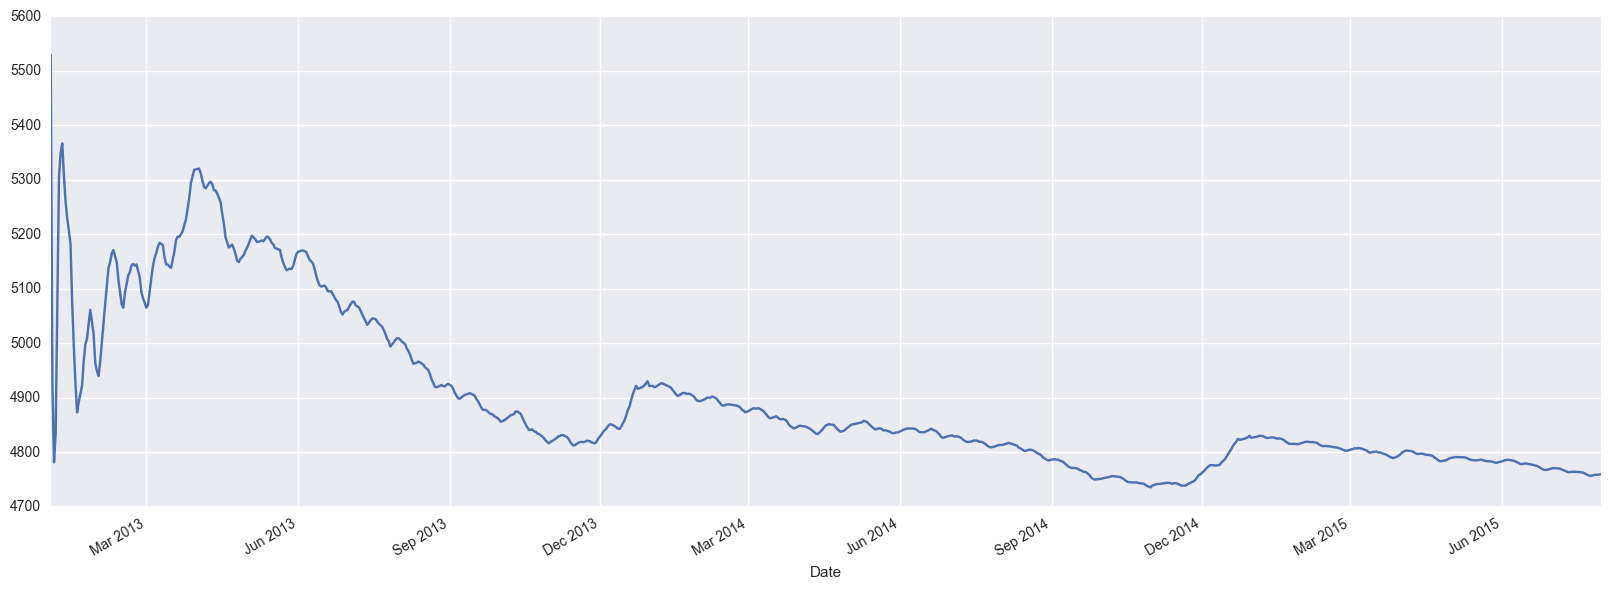

In [69]:
s1d.Sales.expanding().mean().plot(figsize=(20,7))

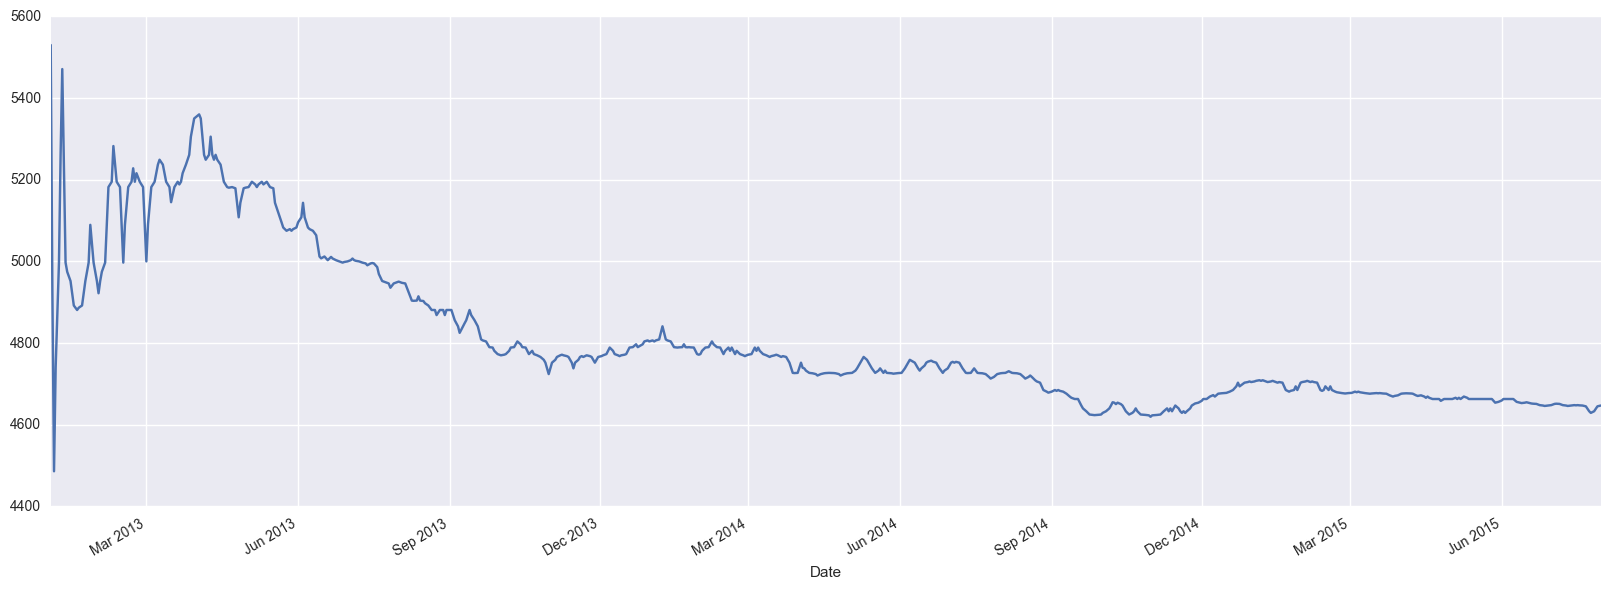

In [71]:
s1d.Sales.expanding().median().plot(figsize=(20,7))

In [76]:
(s1d.Sales.expanding().mean())[-1]

4759.0960307298337

In [ ]:
# resample original sales data mean and median by month
# data2=data[data['Open']==1]
# R2 = data2.Sales.resample('M').mean()
# R2 = data2.Sales.resample('M').median()

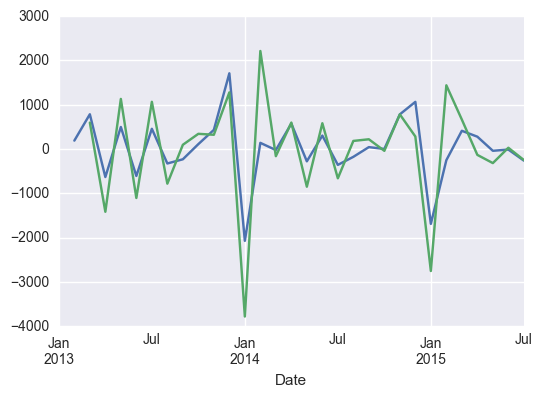

In [100]:
data2=data[data['Open']==1]
R2 = data2.Sales.resample('M').mean()
R2.diff().plot()
(R2.diff()).diff().plot()

In [119]:
for i in range(1,8):
    print data2.Sales.autocorr()

0.261871915037
0.261871915037
0.261871915037
0.261871915037
0.261871915037
0.261871915037
0.261871915037


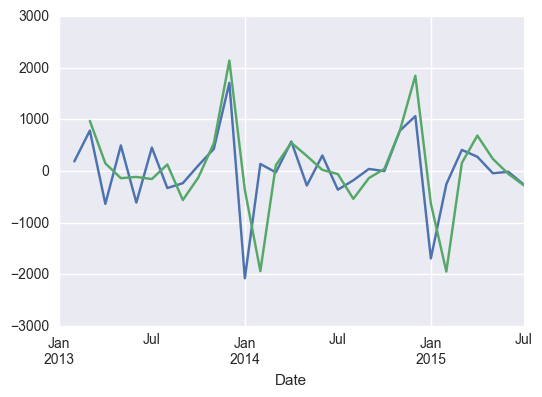

In [101]:
R2.diff().plot()
R2.diff(2).plot()

In [78]:
# computes the average sales, from the first date _until_ the date specified.
#pd.expanding_mean(daily_store_sales).head()

## Exercises

> Plot the distribution of sales by month and compare the effect of promotions

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

> Plot the 15 day rolling mean of customers in the stores

> Identify the date with largest drop in sales from the same date in the previous month

> Compute the total sales up until Dec. 2014

> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`